# Daily Challenges Database Viewer

This notebook allows you to:
1. View all tables in the database
2. Explore the schema and data
3. Visualize the database structure (ERD-like diagram)
4. Run custom queries

In [1]:
# Install required packages if not already installed
# Uncomment the following lines if needed:
# !pip install pandas matplotlib networkx

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# Database path
DB_PATH = Path('challenges.db')

def get_connection():
    """Get a connection to the database"""
    return sqlite3.connect(DB_PATH)

print(f"Database path: {DB_PATH.absolute()}")
print(f"Database exists: {DB_PATH.exists()}")

Database path: /Users/yadanaraung/Education/NTU/Hackathon/ReimagineLearning@NTU_AY2526/nala-hackathon/backend/challenges.db
Database exists: True


## 1. List All Tables

In [3]:
def list_tables():
    """List all tables in the database"""
    conn = get_connection()
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT name FROM sqlite_master 
        WHERE type='table' 
        ORDER BY name
    """)
    
    tables = [row[0] for row in cursor.fetchall()]
    conn.close()
    return tables

tables = list_tables()
print(f"Number of tables: {len(tables)}")
print(f"\nTables:")
for i, table in enumerate(tables, 1):
    print(f"  {i}. {table}")

Number of tables: 4

Tables:
  1. challenge_attempts
  2. challenges
  3. sqlite_sequence
  4. users


## 2. Table Schemas

In [4]:
def get_table_schema(table_name):
    """Get the schema (columns) for a table"""
    conn = get_connection()
    cursor = conn.cursor()
    
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    conn.close()
    return columns

def get_foreign_keys(table_name):
    """Get foreign key relationships for a table"""
    conn = get_connection()
    cursor = conn.cursor()
    
    cursor.execute(f"PRAGMA foreign_key_list({table_name})")
    fks = cursor.fetchall()
    
    conn.close()
    return fks

print("=" * 80)
print("TABLE SCHEMAS")
print("=" * 80)

all_schemas = {}
all_fks = {}

for table in tables:
    print(f"\n{'─' * 40}")
    print(f"Table: {table}")
    print(f"{'─' * 40}")
    
    schema = get_table_schema(table)
    all_schemas[table] = schema
    
    # Display columns
    print(f"{'Column':<25} {'Type':<15} {'PK':<5} {'Not Null':<10} {'Default'}")
    print("-" * 80)
    for col in schema:
        cid, name, dtype, notnull, default, pk = col
        pk_str = '✓' if pk else ''
        nn_str = '✓' if notnull else ''
        default_str = default if default else ''
        print(f"{name:<25} {dtype:<15} {pk_str:<5} {nn_str:<10} {default_str}")
    
    # Display foreign keys
    fks = get_foreign_keys(table)
    all_fks[table] = fks
    
    if fks:
        print(f"\n  Foreign Keys:")
        for fk in fks:
            print(f"    {fk[3]} → {fk[2]}({fk[4]})")

TABLE SCHEMAS

────────────────────────────────────────
Table: challenge_attempts
────────────────────────────────────────
Column                    Type            PK    Not Null   Default
--------------------------------------------------------------------------------
id                        INTEGER         ✓                
user_id                   INTEGER               ✓          
challenge_id              INTEGER               ✓          
attempt_number            INTEGER               ✓          
score                     REAL                             
answer                    TEXT                             
time_spent                TEXT                             
status                    TEXT                             'pending'
created_at                TEXT                             datetime('now')

  Foreign Keys:
    challenge_id → challenges(id)
    user_id → users(id)

────────────────────────────────────────
Table: challenges
──────────────────────────────

## 3. Table Row Counts

In [5]:
def get_row_counts():
    """Get row counts for all tables"""
    conn = get_connection()
    cursor = conn.cursor()
    
    counts = {}
    for table in tables:
        cursor.execute(f"SELECT COUNT(*) FROM {table}")
        counts[table] = cursor.fetchone()[0]
    
    conn.close()
    return counts

row_counts = get_row_counts()

print("\n" + "=" * 40)
print("ROW COUNTS")
print("=" * 40)
print(f"{'Table':<25} {'Rows':>10}")
print("-" * 40)
for table, count in row_counts.items():
    print(f"{table:<25} {count:>10}")
print("-" * 40)
print(f"{'Total':<25} {sum(row_counts.values()):>10}")


ROW COUNTS
Table                           Rows
----------------------------------------
challenge_attempts                30
challenges                        23
sqlite_sequence                    3
users                              1
----------------------------------------
Total                             57


## 4. View Table Data

In [6]:
def view_table(table_name, limit=10):
    """View data from a table as a pandas DataFrame"""
    conn = get_connection()
    df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT {limit}", conn)
    conn.close()
    return df

# View users table
print("\n" + "=" * 60)
print("USERS TABLE")
print("=" * 60)
display(view_table('users'))


USERS TABLE


,id,username,email,created_at
0,1,default_user,user@example.com,2026-01-18 18:03:04


In [7]:
# View challenges table
print("\n" + "=" * 60)
print("CHALLENGES TABLE (first 10 rows)")
print("=" * 60)
challenges_df = view_table('challenges', 10)
# Truncate long columns for display
challenges_df_display = challenges_df.copy()
challenges_df_display['question'] = challenges_df_display['question'].str[:50] + '...'
if 'ground_truth_answer' in challenges_df_display.columns:
    challenges_df_display['ground_truth_answer'] = challenges_df_display['ground_truth_answer'].str[:30] + '...'
display(challenges_df_display)


CHALLENGES TABLE (first 10 rows)


,id,date,category,difficulty,bloom_level,question,ground_truth_answer,acceptance_rate,created_at
0,1,2026-02-03,Linear Systems,Medium,Apply,Systems of Linear Equations: What are the main...,The main methods for solving s...,79.0,2026-01-18 17:53:09
1,2,2026-02-02,Trigonometry,Medium,Analyze,Solving Trigonometric Equations: How do you fi...,To find all solutions to trigo...,72.0,2026-01-18 17:53:09
2,3,2026-02-01,Algebra,Easy,Remember,Laws of Exponents: How do you apply exponent r...,The fundamental laws of expone...,92.0,2026-01-18 17:53:09
3,4,2026-01-31,Calculus,Medium,Understand,Continuity and Differentiability: What's the r...,Continuity and differentiabili...,81.0,2026-01-18 17:53:09
4,5,2026-01-30,Discrete Math,Medium,Apply,Combinations and Permutations: When do you use...,Permutations are used when ORD...,78.0,2026-01-18 17:53:09
5,6,2026-01-29,Analysis,Hard,Analyze,Mean Value Theorem: What does MVT state and wh...,The Mean Value Theorem states:...,62.0,2026-01-18 17:53:09
6,7,2026-01-28,Sequences,Medium,Understand,Convergence of Sequences: When does a sequence...,A sequence {a_n} converges to ...,69.0,2026-01-18 17:53:09
7,8,2026-01-27,Calculus,Hard,Apply,Improper Integrals: How do you evaluate integr...,Improper integrals handle infi...,57.0,2026-01-18 17:53:09
8,9,2026-01-26,Linear Algebra,Medium,Understand,Eigenvalues and Eigenvectors: What do they rep...,"For square matrix A, eigenvalu...",65.0,2026-01-18 17:53:09
9,10,2026-01-25,Statistics,Easy,Remember,Probability Distributions: Which distributions...,Key probability distributions:...,84.0,2026-01-18 17:53:09


In [8]:
# View challenge_attempts table
print("\n" + "=" * 60)
print("CHALLENGE_ATTEMPTS TABLE (first 15 rows)")
print("=" * 60)
attempts_df = view_table('challenge_attempts', 15)
# Truncate long columns for display
attempts_df_display = attempts_df.copy()
if 'answer' in attempts_df_display.columns:
    attempts_df_display['answer'] = attempts_df_display['answer'].str[:40] + '...'
display(attempts_df_display)


CHALLENGE_ATTEMPTS TABLE (first 15 rows)


,id,user_id,challenge_id,attempt_number,score,answer,time_spent,status,created_at
0,3,1,23,1,74.0,Piecewise functions are defined differen...,30 minutes,completed,2026-01-12 10:00:00
1,4,1,23,2,84.0,Piecewise functions are defined differen...,15 minutes,completed,2026-01-12 10:00:00
2,5,1,22,1,58.0,Continuity requires that the limit equal...,10 minutes,completed,2026-01-13 19:00:00
3,6,1,21,1,95.0,"To simplify radicals, I converted them t...",25 minutes,completed,2026-01-14 20:00:00
4,7,1,20,1,85.0,"Permutations are ordered arrangements, c...",12 minutes,completed,2026-01-15 12:00:00
5,8,1,19,1,60.0,I found the critical points by setting t...,5 minutes,completed,2026-01-16 11:00:00
6,9,1,18,1,69.0,I set up the null and alternative hypoth...,30 minutes,completed,2026-01-17 10:00:00
7,10,1,17,1,96.0,I found the critical points by setting t...,8 minutes,completed,2026-01-18 20:00:00
8,11,1,16,1,67.0,Eigenvalues represent the scaling factor...,20 minutes,completed,2026-01-19 19:00:00
9,12,1,15,1,87.0,I used the unit circle and periodicity t...,15 minutes,completed,2026-01-20 18:00:00


## 5. Database ERD (Entity Relationship Diagram)

/var/folders/3v/fdfl0k0d6b7ffjrxfy8_mb2m0000gn/T/ipykernel_11821/478317959.py:103: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3v/fdfl0k0d6b7ffjrxfy8_mb2m0000gn/T/ipykernel_11821/478317959.py:104: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  plt.savefig('database_erd.png', dpi=150, bbox_inches='tight', facecolor='white')
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


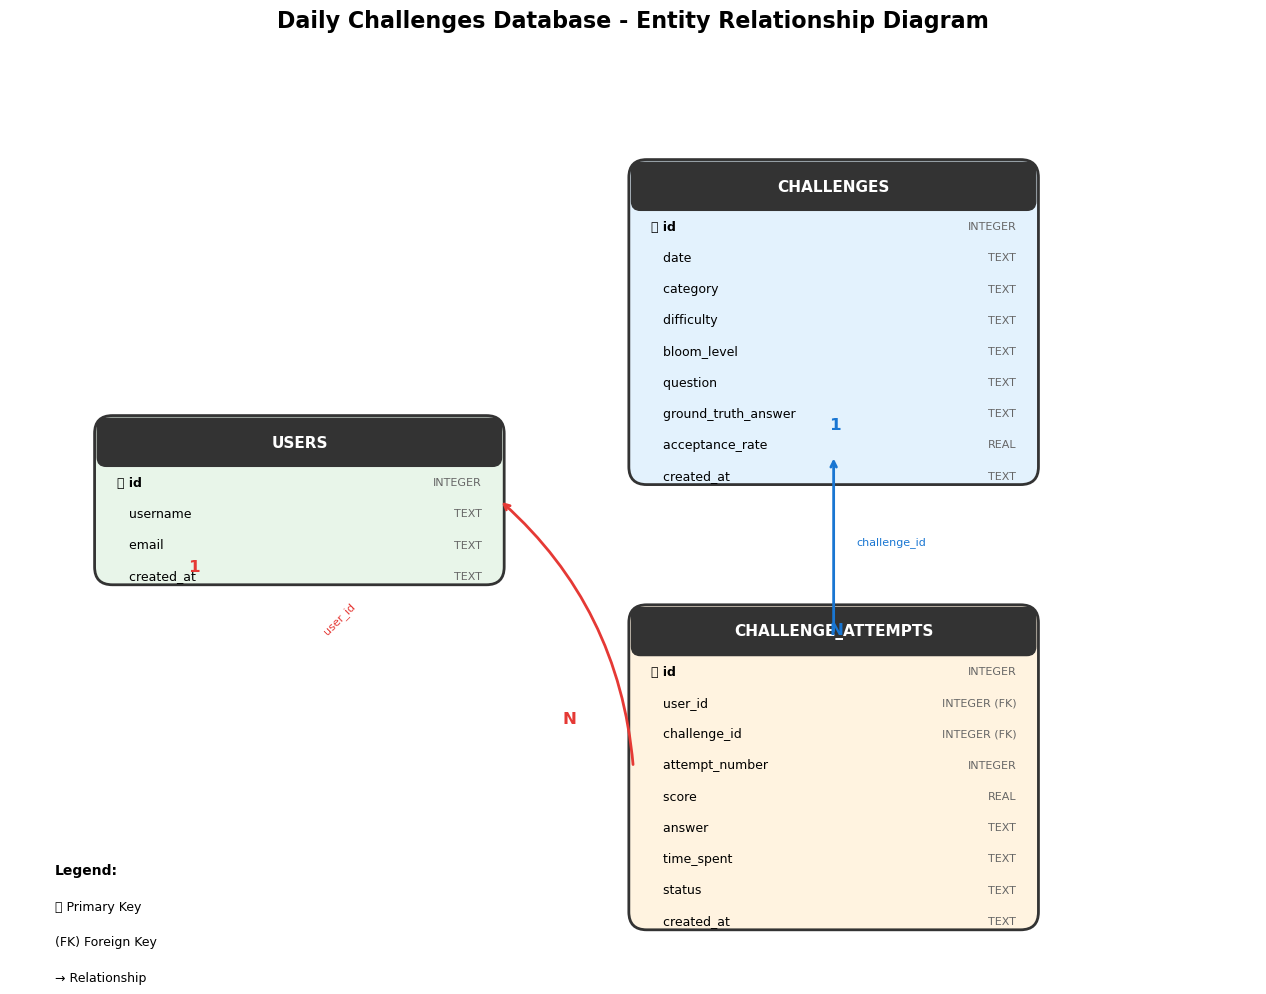


ERD saved to 'database_erd.png'


In [ ]:
def draw_erd():
    """Draw an ERD-like diagram showing tables and relationships"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Daily Challenges Database - Entity Relationship Diagram', fontsize=16, fontweight='bold', pad=20)
    
    # Table positions
    positions = {
        'users': (1, 5),
        'challenges': (7, 7),
        'challenge_attempts': (7, 2),
    }
    
    # Table colors
    colors = {
        'users': '#E8F5E9',  # Light green
        'challenges': '#E3F2FD',  # Light blue
        'challenge_attempts': '#FFF3E0',  # Light orange
    }
    
    # Draw tables
    table_boxes = {}
    for table, (x, y) in positions.items():
        schema = all_schemas.get(table, [])
        
        # Calculate box height based on number of columns
        box_height = 0.4 + len(schema) * 0.35
        box_width = 4.5
        
        # Draw table box
        rect = mpatches.FancyBboxPatch(
            (x, y - box_height/2), box_width, box_height,
            boxstyle="round,pad=0.05,rounding_size=0.2",
            facecolor=colors.get(table, '#FFFFFF'),
            edgecolor='#333333',
            linewidth=2
        )
        ax.add_patch(rect)
        table_boxes[table] = (x, y, box_width, box_height)
        
        # Draw table name header
        header_rect = mpatches.FancyBboxPatch(
            (x, y + box_height/2 - 0.5), box_width, 0.5,
            boxstyle="round,pad=0.02,rounding_size=0.1",
            facecolor='#333333',
            edgecolor='#333333',
            linewidth=1
        )
        ax.add_patch(header_rect)
        
        ax.text(x + box_width/2, y + box_height/2 - 0.25, table.upper(),
                ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        
        # Draw column names
        col_y = y + box_height/2 - 0.7
        for col in schema:
            cid, name, dtype, notnull, default, pk = col
            
            # Format column text
            prefix = '🔑 ' if pk else '   '
            suffix = ' (FK)' if any(fk[3] == name for fk in all_fks.get(table, [])) else ''
            dtype_short = dtype[:10] if len(dtype) > 10 else dtype
            
            ax.text(x + 0.2, col_y, f"{prefix}{name}",
                    ha='left', va='center', fontsize=9,
                    fontweight='bold' if pk else 'normal')
            ax.text(x + box_width - 0.2, col_y, f"{dtype_short}{suffix}",
                    ha='right', va='center', fontsize=8, color='#666666')
            col_y -= 0.35
    
    # Draw relationships (foreign keys)
    # challenge_attempts.user_id -> users.id
    ax.annotate('', 
                xy=(positions['users'][0] + 4.5, positions['users'][1]),
                xytext=(positions['challenge_attempts'][0], positions['challenge_attempts'][1]),
                arrowprops=dict(arrowstyle='->', color='#E53935', lw=2,
                               connectionstyle='arc3,rad=0.2'))
    ax.text(3.5, 3.5, 'user_id', fontsize=8, color='#E53935', rotation=45)
    
    # challenge_attempts.challenge_id -> challenges.id
    ax.annotate('',
                xy=(positions['challenges'][0] + 2.25, positions['challenges'][1] - 1.5),
                xytext=(positions['challenge_attempts'][0] + 2.25, positions['challenge_attempts'][1] + 1.5),
                arrowprops=dict(arrowstyle='->', color='#1976D2', lw=2))
    ax.text(9.5, 4.5, 'challenge_id', fontsize=8, color='#1976D2')
    
    # Add legend
    legend_y = 0.8
    ax.text(0.5, legend_y, 'Legend:', fontsize=10, fontweight='bold')
    ax.text(0.5, legend_y - 0.4, '🔑 Primary Key', fontsize=9)
    ax.text(0.5, legend_y - 0.8, '(FK) Foreign Key', fontsize=9)
    ax.text(0.5, legend_y - 1.2, '→ Relationship', fontsize=9)
    
    # Add cardinality labels
    ax.text(2, 4.2, '1', fontsize=12, fontweight='bold', color='#E53935')
    ax.text(6.2, 2.5, 'N', fontsize=12, fontweight='bold', color='#E53935')
    ax.text(9.2, 5.8, '1', fontsize=12, fontweight='bold', color='#1976D2')
    ax.text(9.2, 3.5, 'N', fontsize=12, fontweight='bold', color='#1976D2')
    
    plt.tight_layout()
    plt.show()

draw_erd()

## 6. Statistics and Analytics

In [10]:
# Challenge statistics
conn = get_connection()

# Challenges by category
print("\n" + "=" * 50)
print("CHALLENGES BY CATEGORY")
print("=" * 50)
df_category = pd.read_sql_query("""
    SELECT category, COUNT(*) as count, 
           AVG(acceptance_rate) as avg_acceptance_rate
    FROM challenges 
    GROUP BY category 
    ORDER BY count DESC
""", conn)
display(df_category)

# Challenges by difficulty
print("\n" + "=" * 50)
print("CHALLENGES BY DIFFICULTY")
print("=" * 50)
df_difficulty = pd.read_sql_query("""
    SELECT difficulty, COUNT(*) as count,
           AVG(acceptance_rate) as avg_acceptance_rate
    FROM challenges 
    GROUP BY difficulty
    ORDER BY 
        CASE difficulty 
            WHEN 'Easy' THEN 1 
            WHEN 'Medium' THEN 2 
            WHEN 'Hard' THEN 3 
        END
""", conn)
display(df_difficulty)

conn.close()


CHALLENGES BY CATEGORY


,category,count,avg_acceptance_rate
0,Calculus,6,72.000000
1,Algebra,3,85.000000
2,Discrete Math,3,79.666667
3,Functions,2,75.000000
4,Linear Algebra,2,61.500000
5,Statistics,2,77.500000
6,Trigonometry,2,80.500000
7,Analysis,1,62.000000
8,Linear Systems,1,79.000000
9,Sequences,1,69.000000



CHALLENGES BY DIFFICULTY


,difficulty,count,avg_acceptance_rate
0,Easy,6,88.166667
1,Medium,13,73.692308
2,Hard,4,59.500000


In [11]:
# Attempt statistics
conn = get_connection()

print("\n" + "=" * 50)
print("ATTEMPT STATISTICS BY USER")
print("=" * 50)
df_user_stats = pd.read_sql_query("""
    SELECT 
        u.id as user_id,
        u.username,
        COUNT(ca.id) as total_attempts,
        COUNT(DISTINCT ca.challenge_id) as challenges_attempted,
        ROUND(AVG(ca.score), 2) as avg_score,
        SUM(CASE WHEN ca.status = 'completed' THEN 1 ELSE 0 END) as completed
    FROM users u
    LEFT JOIN challenge_attempts ca ON u.id = ca.user_id
    GROUP BY u.id
""", conn)
display(df_user_stats)

conn.close()


ATTEMPT STATISTICS BY USER


,user_id,username,total_attempts,challenges_attempted,avg_score,completed
0,1,default_user,30,23,72.17,30


In [12]:
# Challenges with multiple attempts
conn = get_connection()

print("\n" + "=" * 50)
print("CHALLENGES WITH MULTIPLE ATTEMPTS (showing improvement)")
print("=" * 50)
df_multi = pd.read_sql_query("""
    SELECT 
        c.date,
        c.category,
        c.difficulty,
        SUBSTR(c.question, 1, 40) || '...' as question,
        COUNT(ca.id) as attempts,
        MIN(ca.score) as first_score,
        MAX(ca.score) as best_score,
        MAX(ca.score) - MIN(ca.score) as improvement
    FROM challenges c
    JOIN challenge_attempts ca ON c.id = ca.challenge_id
    GROUP BY c.id
    HAVING COUNT(ca.id) > 1
    ORDER BY improvement DESC
    LIMIT 10
""", conn)
display(df_multi)

conn.close()


CHALLENGES WITH MULTIPLE ATTEMPTS (showing improvement)


,date,category,difficulty,question,attempts,first_score,best_score,improvement
0,2026-01-31,Calculus,Medium,Continuity and Differentiability: What's...,3,20.0,91.0,71.0
1,2026-01-22,Calculus,Medium,Concavity and Inflection Points: How do ...,2,63.0,92.0,29.0
2,2026-01-21,Algebra,Medium,Rational Functions: What are their prope...,2,74.0,91.0,17.0
3,2026-01-19,Linear Algebra,Hard,Vector Spaces and Subspaces: What define...,2,67.0,82.0,15.0
4,2026-01-12,Functions,Medium,"Piecewise Functions: How do you define, ...",2,74.0,84.0,10.0
5,2026-01-28,Sequences,Medium,Convergence of Sequences: When does a se...,2,81.0,86.0,5.0


## 7. Custom Query

In [13]:
def run_query(sql):
    """Run a custom SQL query and return results as DataFrame"""
    conn = get_connection()
    try:
        df = pd.read_sql_query(sql, conn)
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        conn.close()

# Example: Custom query
# Modify the SQL below to run your own queries
custom_sql = """
SELECT 
    date,
    category,
    difficulty,
    bloom_level,
    acceptance_rate
FROM challenges
WHERE date >= '2026-01-19'
ORDER BY date DESC
LIMIT 5
"""

print("Custom Query Results:")
display(run_query(custom_sql))

Custom Query Results:


,date,category,difficulty,bloom_level,acceptance_rate
0,2026-02-03,Linear Systems,Medium,Apply,79.0
1,2026-02-02,Trigonometry,Medium,Analyze,72.0
2,2026-02-01,Algebra,Easy,Remember,92.0
3,2026-01-31,Calculus,Medium,Understand,81.0
4,2026-01-30,Discrete Math,Medium,Apply,78.0


## 8. Visualizations

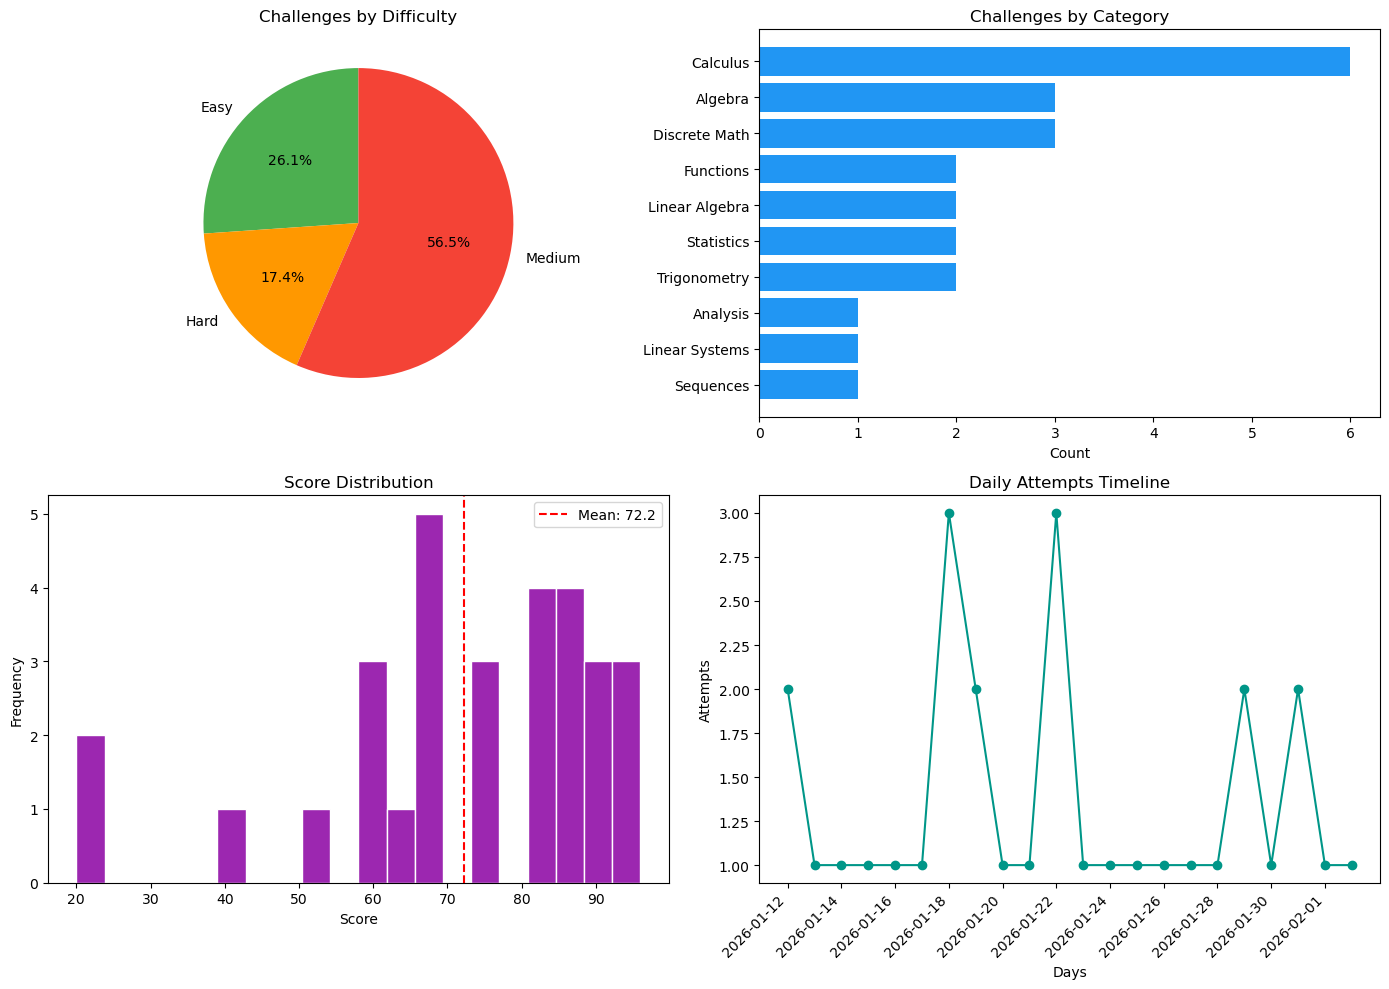

In [16]:
conn = get_connection()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Challenges by difficulty pie chart
df_diff = pd.read_sql_query("""
    SELECT difficulty, COUNT(*) as count
    FROM challenges
    GROUP BY difficulty
""", conn)
colors_pie = ['#4CAF50', '#FF9800', '#F44336']
axes[0, 0].pie(df_diff['count'], labels=df_diff['difficulty'], autopct='%1.1f%%', 
               colors=colors_pie, startangle=90)
axes[0, 0].set_title('Challenges by Difficulty')

# 2. Challenges by category bar chart
df_cat = pd.read_sql_query("""
    SELECT category, COUNT(*) as count
    FROM challenges
    GROUP BY category
    ORDER BY count DESC
""", conn)
axes[0, 1].barh(df_cat['category'], df_cat['count'], color='#2196F3')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_title('Challenges by Category')
axes[0, 1].invert_yaxis()

# 3. Score distribution
df_scores = pd.read_sql_query("""
    SELECT score FROM challenge_attempts WHERE score IS NOT NULL
""", conn)
axes[1, 0].hist(df_scores['score'], bins=20, color='#9C27B0', edgecolor='white')
axes[1, 0].set_xlabel('Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Score Distribution')
axes[1, 0].axvline(df_scores['score'].mean(), color='red', linestyle='--', label=f'Mean: {df_scores["score"].mean():.1f}')
axes[1, 0].legend()

# 4. Attempts over time
df_timeline = pd.read_sql_query("""
    SELECT date(created_at) as date, COUNT(*) as attempts
    FROM challenge_attempts
    GROUP BY date(created_at)
    ORDER BY date
""", conn)
if not df_timeline.empty:
    axes[1, 1].plot(range(len(df_timeline)), df_timeline['attempts'], marker='o', color='#009688')
    axes[1, 1].set_xlabel('Days')
    axes[1, 1].set_ylabel('Attempts')
    axes[1, 1].set_title('Daily Attempts Timeline')
    # Show only some x-labels
    if len(df_timeline) > 10:
        tick_indices = range(0, len(df_timeline), len(df_timeline)//10)
        axes[1, 1].set_xticks(tick_indices)
        axes[1, 1].set_xticklabels([df_timeline['date'].iloc[i] for i in tick_indices], rotation=45, ha='right')

plt.tight_layout()
plt.show()

conn.close()